<a href="https://colab.research.google.com/github/Muhammedesit/stock-prediction-projrct/blob/main/Bioinformatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jkwang93/AMP-Designer.git


Cloning into 'AMP-Designer'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 144 (delta 62), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 14.89 MiB | 6.28 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
import pandas as pd

amp_path = "/content/AMP-Designer/data/prompt_data/amp_data.csv"
non_amp_path = "/content/AMP-Designer/data/prompt_data/nonamp_data.csv"

# Dosyaların başlıkları olmadığı için header=None ile okuyup sütun ismini elle veriyoruz
df_amp = pd.read_csv(amp_path, header=None, names=["sequence"])
df_non_amp = pd.read_csv(non_amp_path, header=None, names=["sequence"])


In [ ]:

# Etiketleri ekleyelim
df_amp["label"] = 1
df_non_amp["label"] = 0

# Birleştir, karıştır ve sadece gerekli sütunları al
df_all = pd.concat([df_amp, df_non_amp], ignore_index=True)
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all = df_all[["sequence", "label"]]

df_all.head()

,sequence,label
0,SVIGCWTKSIPPRPCFVK,1
1,RKRFARFAKRAV,1
2,FFGWLIKGAIHAPKAIHGLIHRRRH,1
3,GLFVGLAKVAAHNNPAIAEHFQA,1
4,LKWLKKWLK,1


In [ ]:
!pip install biopython
!pip install modlamp
!pip install protlearn


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def extract_basic_features(seq):
    try:
        analysis = ProteinAnalysis(seq)
        return {
            "length": len(seq),
            "molecular_weight": analysis.molecular_weight(),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "isoelectric_point": analysis.isoelectric_point(),
            "gravy": analysis.gravy()
        }
    except:
        return {
            "length": 0, "molecular_weight": 0,
            "aromaticity": 0, "instability_index": 0,
            "isoelectric_point": 0, "gravy": 0
        }

features = df_all["sequence"].apply(extract_basic_features)
features_df = pd.DataFrame(features.tolist())

df_features = pd.concat([features_df, df_all["label"]], axis=1)
df_features.head()


,length,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,label
0,18,2018.4477,0.111111,24.072222,9.499755,0.250000,1
1,12,1505.8150,0.166667,63.500000,11.999968,-0.883333,1
2,25,2932.4801,0.120000,81.176000,11.999968,-0.048000,1
3,23,2375.6822,0.086957,8.121739,6.920852,0.443478,1
4,9,1242.5971,0.222222,8.011111,10.477740,-0.666667,1


In [ ]:
from sklearn.model_selection import StratifiedKFold

X = df_features.drop("label", axis=1)
y = df_features["label"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1} → Train size: {len(train_index)}, Test size: {len(test_index)}")


Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439


In [ ]:
!pip install xgboost catboost scikit-learn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def evaluate_model(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    metrics = {
        "accuracy": [], "f1": [], "auc": [],
        "mcc": [], "sensitivity": [], "specificity": []
    }

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1} → Train size: {len(train_idx)}, Test size: {len(test_idx)}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["auc"].append(roc_auc_score(y_test, y_prob))
        metrics["mcc"].append(matthews_corrcoef(y_test, y_pred))
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)

    # Ortalamaları hesapla
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics


In [ ]:
X = df_features.drop("label", axis=1)
y = df_features["label"]

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    metrics = evaluate_model(model, X, y)
    results[name] = metrics



🚀 Training: Random Forest
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439

🚀 Training: XGBoost
Fold 1 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 → Train size: 9760, Test size: 2439


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🚀 Training: AdaBoost
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439

🚀 Training: CatBoost
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439

🚀 Training: SVM
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439


,accuracy,auc,f1,mcc,sensitivity,specificity
Random Forest,0.821378,0.787416,0.895676,0.307025,0.945231,0.289173
XGBoost,0.818755,0.768044,0.894173,0.295187,0.943917,0.280919
AdaBoost,0.813837,0.730140,0.894610,0.188699,0.974030,0.125483
CatBoost,0.824412,0.782284,0.899023,0.288036,0.963724,0.225781
SVM,0.811214,0.541284,0.895768,0.000000,1.000000,0.000000


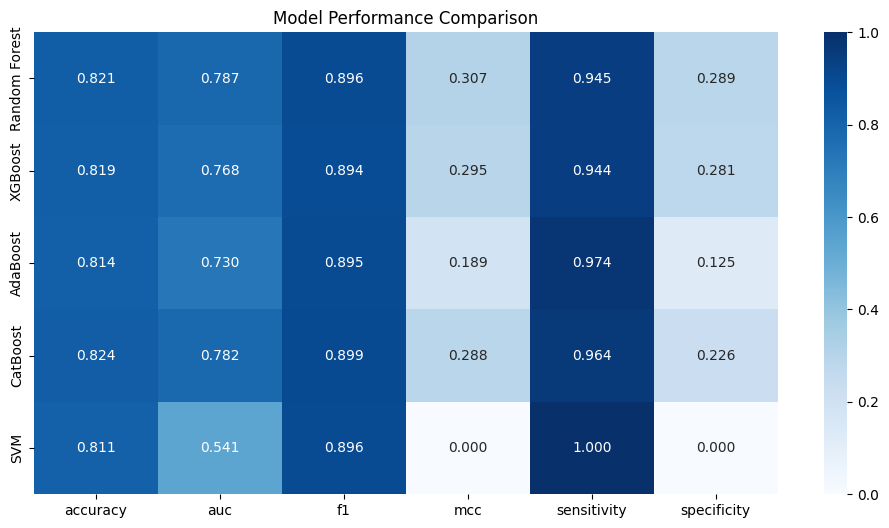

In [ ]:
results_df = pd.DataFrame(results).T
results_df = results_df[["accuracy", "auc", "f1", "mcc", "sensitivity", "specificity"]]
display(results_df)

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-12-491035a38ca1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")


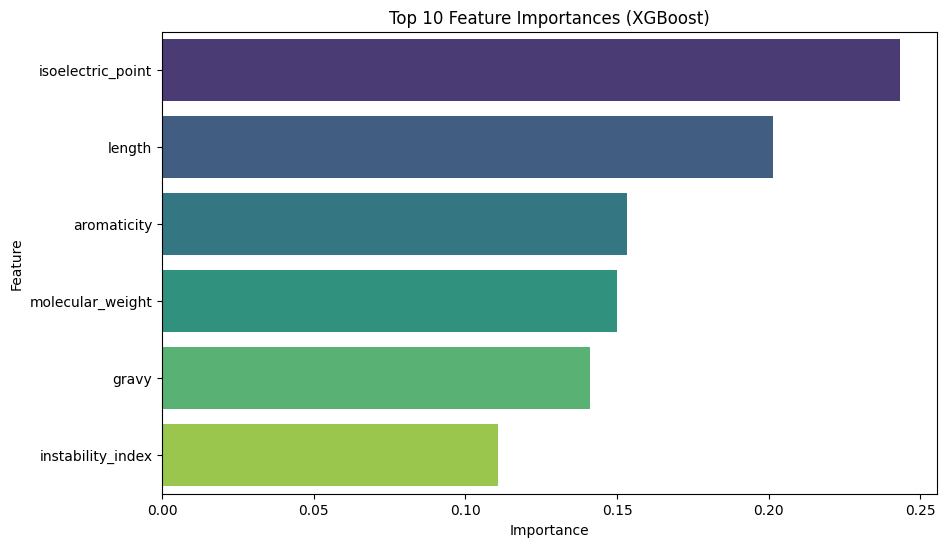

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X, y)

importances = xgb_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Top 5 Selected Features:", selected_features.tolist())


Top 5 Selected Features: ['length', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point']


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, matthews_corrcoef

def cross_validate_model(model, X, y, kf):
    metrics = {
        "accuracy": [], "f1": [], "auc": [],
        "mcc": [], "sensitivity": [], "specificity": []
    }

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["auc"].append(roc_auc_score(y_test, y_prob))
        metrics["mcc"].append(matthews_corrcoef(y_test, y_pred))
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)

    return {k: np.mean(v) for k, v in metrics.items()}


In [ ]:
from sklearn.model_selection import KFold

selected_features = ['length', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point']
X_selected = df_features[selected_features]
y = df_features["label"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_selected = []

for name, model in models.items():
    print(f"🚀 Training with selected features: {name}")
    metrics = cross_validate_model(model, X_selected, y, kf)
    metrics["model"] = name + "_selected"
    results_selected.append(metrics)

df_results_selected = pd.DataFrame(results_selected)


🚀 Training with selected features: Random Forest
🚀 Training with selected features: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🚀 Training with selected features: AdaBoost
🚀 Training with selected features: CatBoost
🚀 Training with selected features: SVM


In [ ]:
df_results = results_df.reset_index().rename(columns={"index": "model"})

df_all_results = pd.concat([df_results, df_results_selected], ignore_index=True)
df_all_results = df_all_results.sort_values(by="accuracy", ascending=False)

display(df_all_results)


,model,accuracy,auc,f1,mcc,sensitivity,specificity
8,CatBoost_selected,0.824575,0.770463,0.899427,0.281007,0.967058,0.211955
3,CatBoost,0.824412,0.782284,0.899023,0.288036,0.963724,0.225781
0,Random Forest,0.821378,0.787416,0.895676,0.307025,0.945231,0.289173
1,XGBoost,0.818755,0.768044,0.894173,0.295187,0.943917,0.280919
5,Random Forest_selected,0.817525,0.768072,0.893026,0.298625,0.938968,0.295141
6,XGBoost_selected,0.816050,0.753369,0.892879,0.276385,0.945033,0.261255
2,AdaBoost,0.813837,0.730140,0.894610,0.188699,0.974030,0.125483
7,AdaBoost_selected,0.812690,0.713208,0.893962,0.181318,0.973422,0.122162
9,SVM_selected,0.811215,0.513468,0.895761,0.000000,1.000000,0.000000
4,SVM,0.811214,0.541284,0.895768,0.000000,1.000000,0.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

logitboost = AdaBoostClassifier(
    estimator=LogisticRegression(solver='liblinear'),
    n_estimators=50,
    random_state=42
)


In [ ]:
# Tüm modellerle yeniden değerlendirme
for name, model in models.items():
    print(f"🚀 Training: {name}")
    metrics = evaluate_model(model, X, y)
    results[name] = metrics


🚀 Training: Random Forest
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439
🚀 Training: XGBoost
Fold 1 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 → Train size: 9759, Test size: 2440


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 → Train size: 9760, Test size: 2439


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 Training: AdaBoost
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439
🚀 Training: CatBoost
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439
🚀 Training: SVM
Fold 1 → Train size: 9759, Test size: 2440
Fold 2 → Train size: 9759, Test size: 2440
Fold 3 → Train size: 9759, Test size: 2440
Fold 4 → Train size: 9759, Test size: 2440
Fold 5 → Train size: 9760, Test size: 2439


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
X_rfe = rfe_selector.fit_transform(X, y)

selected_features_rfe = X.columns[rfe_selector.get_support()]
print("RFE Selected Features:", selected_features_rfe.tolist())


RFE Selected Features: ['molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'gravy']


In [ ]:
models["LogitBoost"] = logitboost


🚀 RFE Features - Training: Random Forest
🚀 RFE Features - Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🚀 RFE Features - Training: AdaBoost
🚀 RFE Features - Training: CatBoost
🚀 RFE Features - Training: SVM
🚀 RFE Features - Training: LogitBoost


,model,accuracy,auc,f1,mcc,sensitivity,specificity
8,CatBoost_selected,0.824575,0.770463,0.899427,0.281007,0.967058,0.211955
13,CatBoost_rfe,0.824494,0.772541,0.899432,0.279451,0.967643,0.209169
3,CatBoost,0.824412,0.782284,0.899023,0.288036,0.963724,0.225781
0,Random Forest,0.821378,0.787416,0.895676,0.307025,0.945231,0.289173
10,Random Forest_rfe,0.820313,0.782464,0.895110,0.300734,0.945222,0.283214
1,XGBoost,0.818755,0.768044,0.894173,0.295187,0.943917,0.280919
11,XGBoost_rfe,0.818673,0.761267,0.894110,0.294290,0.943715,0.280748
5,Random Forest_selected,0.817525,0.768072,0.893026,0.298625,0.938968,0.295141
6,XGBoost_selected,0.816050,0.753369,0.892879,0.276385,0.945033,0.261255
12,AdaBoost_rfe,0.814740,0.712277,0.895332,0.187723,0.976943,0.117693


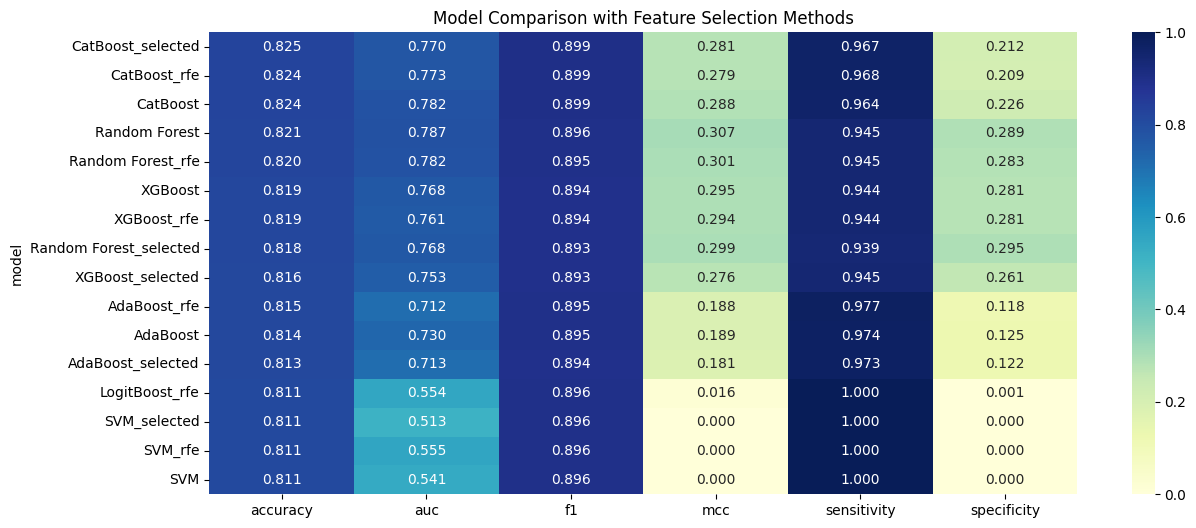

In [ ]:
# RFE ile seçilen özelliklerle değerlendirme
X_rfe_selected = df_features[selected_features_rfe]
y = df_features["label"]

results_rfe = []

for name, model in models.items():
    print(f"🚀 RFE Features - Training: {name}")
    metrics = cross_validate_model(model, X_rfe_selected, y, kf)
    metrics["model"] = name + "_rfe"
    results_rfe.append(metrics)

df_results_rfe = pd.DataFrame(results_rfe)

# Tüm sonuçları birleştir
df_all_results = pd.concat([df_results, df_results_selected, df_results_rfe], ignore_index=True)
df_all_results = df_all_results.sort_values(by="accuracy", ascending=False)

# Görüntüle
display(df_all_results)

# Opsiyonel: görselleştirme
plt.figure(figsize=(14, 6))
sns.heatmap(df_all_results.set_index("model"), annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Comparison with Feature Selection Methods")
plt.show()
